In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, auc

In [28]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/nn-from-scratch/creditcard.csv')
data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


###Funções da rede neural

In [29]:
def initialize_weights(input_size, hidden_size, output_size):
    np.random.seed(1)
    W1 = np.random.randn(input_size, hidden_size) * 0.01
    b1 = np.zeros((1, hidden_size))
    W2 = np.random.randn(hidden_size, output_size) * 0.01
    b2 = np.zeros((1, output_size))
    return W1, b1, W2, b2

def relu(Z):
  return np.maximun(0, Z)

def relu_derivative(Z):
  return Z > 0

def sigmoid(Z):
  return 1 / (1 + np.exp(-Z))

def sigmoid_derivative(Z):
  return sigmoid(Z) * (1 - sigmoid(Z))

def forward_propagation(X, W1, b1, W2, b2):
  Z1 = np.dot(X, W1) + b1
  A1 = sigmoid(Z1)
  Z2 = np.dot(A1, W2) + b2
  A2 = sigmoid(Z2)
  return Z1, A1, Z2, A2


def backward_propagation(X, y, Z1, A1, Z2, A2, W1, W2):
    m = X.shape[0]
    dZ2 = A2 - y
    dW2 = np.dot(A1.T, dZ2) / m
    db2 = np.sum(dZ2, axis=0) / m

    dZ1 = np.dot(dZ2, W2.T) * relu_derivative(Z1)
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0) / m

    return dW1, db1, dW2, db2

def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    return W1, b1, W2, b2

def train_neural_network(X_train, y_train, hidden_size, epochs, learning_rate):
    input_size = X_train.shape[1]
    output_size = 1

    W1, b1, W2, b2 = initialize_weights(input_size, hidden_size, output_size)

    loss_history = []

    for epoch in range(epochs):
        Z1, A1, Z2, A2 = forward_propagation(X_train, W1, b1, W2, b2)

        loss = -np.mean(y_train * np.log(A2) + (1 - y_train) * np.log(1 - A2))
        loss_history.append(loss)

        dW1, db1, dW2, db2 = backward_propagation(X_train, y_train, Z1, A1, Z2, A2, W1, W2)

        W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)

        if epoch % 200 == 0:
            print(f"Epoch {epoch}: Loss = {loss}")

    return W1, b1, W2, b2, loss_history

def predict(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_propagation(X, W1, b1, W2, b2)
    return (A2 > 0.5)

def evaluate_model(X_test, y_test, W1, b1, W2, b2):
    y_pred = predict(X_test, W1, b1, W2, b2)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    auprc = auc(recall, precision)

    print(f"Acurácia: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"AUPRC: {auprc}")

### Pre-processamento dos dados:

In [32]:
X = data.drop(columns=['Class'])
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#Realiza o undersampling para lidar com o debalanceamento de dados
undersample = RandomUnderSampler(sampling_strategy=1, random_state=42)
X_train_res, y_train_res = undersample.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)


print(f"Distribuição das classes no conjunto de treino: {pd.Series(y_train_res).value_counts().to_string()}")
print(f"Distribuição das classes no conjunto de teste: {pd.Series(y_test).value_counts().to_string()}")

Distribuição das classes no conjunto de treino: Class
0    394
1    394
Distribuição das classes no conjunto de teste: Class
0    56864
1       98


###Treinamento e avaliação do modelo

Epoch 0: Loss = 0.6928703908751024
Epoch 200: Loss = 0.6925940953627634
Epoch 400: Loss = 0.692347039622281
Epoch 600: Loss = 0.692093031425366
Epoch 800: Loss = 0.691814951731972
Epoch 1000: Loss = 0.6915043011491897
Epoch 1200: Loss = 0.6911528228941103
Epoch 1400: Loss = 0.6907509230197678
Epoch 1600: Loss = 0.6902911657178938
Epoch 1800: Loss = 0.6897637726099687
Epoch 2000: Loss = 0.6891579645875137
Epoch 2200: Loss = 0.6884596285914762
Epoch 2400: Loss = 0.6876539516954626
Epoch 2600: Loss = 0.6867222397285615
Epoch 2800: Loss = 0.6856441439488168

Acurácia: 0.9993153330290369
F1 Score: 0.7979274611398963
AUPRC: 0.7983046341671389


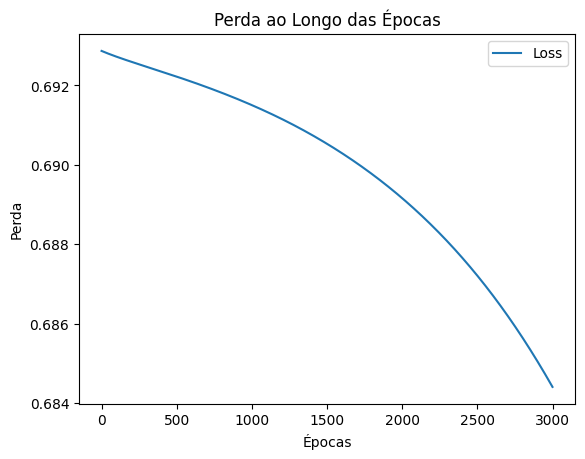

In [31]:
hidden_size = 50
epochs = 3000
learning_rate = 0.001

W1, b1, W2, b2, loss_history = train_neural_network(X_train_res, y_train_res.values.reshape(-1, 1), hidden_size, epochs, learning_rate)

print()
evaluate_model(X_test, y_test.values.reshape(-1, 1), W1, b1, W2, b2)

plt.plot(range(epochs), loss_history, label='Loss')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.title('Perda ao Longo das Épocas')
plt.legend()
plt.show()